In [1]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_concurrency_parallelism(cc_value):
    value = int(sqrt(cc_value))
    return value, value

def process_log_files(directory,string):
    dataframes = []
    for filename in os.listdir(directory):
        if filename.startswith(string) and filename.endswith(".log"):
            full_path = os.path.join(directory, filename)
            if os.stat(full_path).st_size == 0:
                print(f"Skipping empty file: {filename}")
                continue
            with open(full_path, 'r') as file:
                data = []
                last_non_zero_throughput = None
                for line in file:
                    match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+) CC:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:(\d+\.\d+)', line)
                    if match:
                        time = datetime.fromtimestamp(float(match.group(1)))
                        throughput = float(match.group(3))
                        if throughput == 0.00 and last_non_zero_throughput is not None:
                            throughput = last_non_zero_throughput
                        elif throughput != 0.00:
                            last_non_zero_throughput = throughput

                        loss_rate = float(match.group(4))
                        cc = int(match.group(5))
                        score = float(match.group(6))
                        rtt = float(match.group(7))
                        energy = float(match.group(8))
                        sender_lr = float(match.group(9))
                        concurrency, parallelism = get_concurrency_parallelism(cc)
                        data.append([time, throughput, loss_rate, cc, score, rtt, energy, sender_lr, concurrency, parallelism])

                if data:
                    df = pd.DataFrame(data, columns=['Time', 'Throughput', 'receiver_lr', 'CC', 'Score', 'RTT', 'Energy', 'sender_lr', 'concurrency', 'parallelism'])
                    dataframes.append(df)
                else:
                    print(f"No valid data in file: {filename}")
    return dataframes



                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-27 05:55:35.787937        0.00          0.0   1    0.0   0.0   
1   2023-12-27 05:55:36.786037        0.00          0.0   4    0.0   0.0   
2   2023-12-27 05:55:37.787215        0.00          0.0   4    0.0  32.7   
3   2023-12-27 05:55:38.787035        0.00          0.0   4    0.0  32.6   
4   2023-12-27 05:55:39.788103        0.00          0.0   4    0.0  32.7   
..                         ...         ...          ...  ..    ...   ...   
334 2023-12-27 06:01:10.140568        0.32          0.0   1    0.0  32.7   
335 2023-12-27 06:01:11.141031        0.32          0.0   1    0.0  32.6   
336 2023-12-27 06:01:12.142754        0.32          0.0   1    0.0  32.8   
337 2023-12-27 06:01:13.144045        0.32          0.0   1    0.0  32.8   
338 2023-12-27 06:01:14.144307        0.32          0.0   1    0.0  32.7   

     Energy  sender_lr  concurrency  parallelism  
0       0.0        0.0            1 

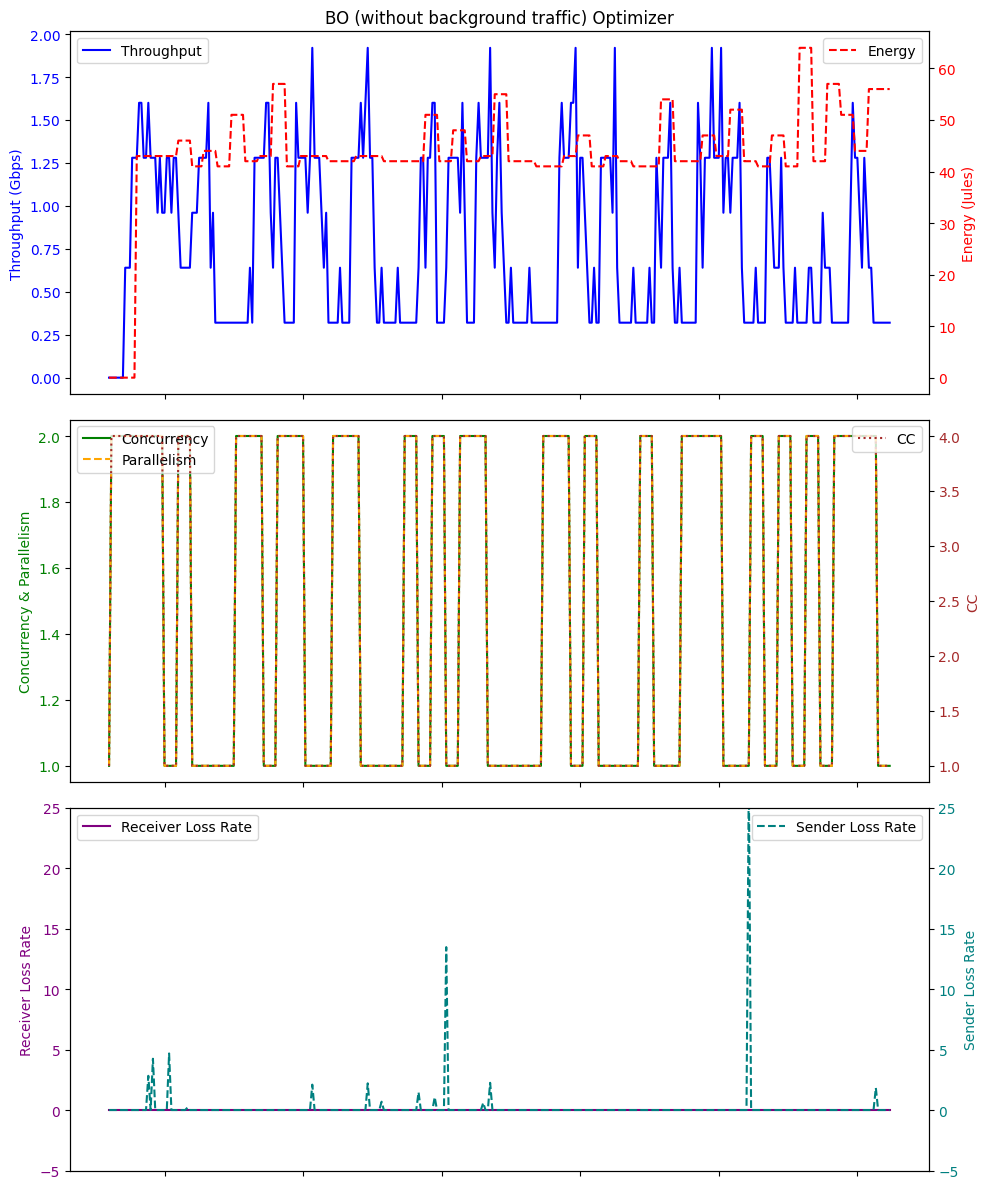

Average Throughput: 0.7712094395280236
Total Energy: 14745.0
Total loss rate: 65.16971854353793
                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 05:41:58.724156        0.00          0.0   1    0.0   0.0   
1  2023-12-27 05:41:59.722263        0.00          0.0  49    0.0   0.0   
2  2023-12-27 05:42:00.721910        0.00          0.0  49    0.0  32.6   
3  2023-12-27 05:42:01.721913        0.00          0.0  49    0.0  32.7   
4  2023-12-27 05:42:02.723367        0.00          0.0  49    0.0  32.7   
..                        ...         ...          ...  ..    ...   ...   
64 2023-12-27 05:43:02.785056        0.64          0.0  49    0.0  32.6   
65 2023-12-27 05:43:03.786965        0.64          0.0  49    0.0  32.7   
66 2023-12-27 05:43:04.788153        0.64          0.0  49    0.0  32.7   
67 2023-12-27 05:43:05.787877        0.64          0.0  49    0.0  32.7   
68 2023-12-27 05:43:06.791325        0.64          0.0  49    0.0  32.7   

   

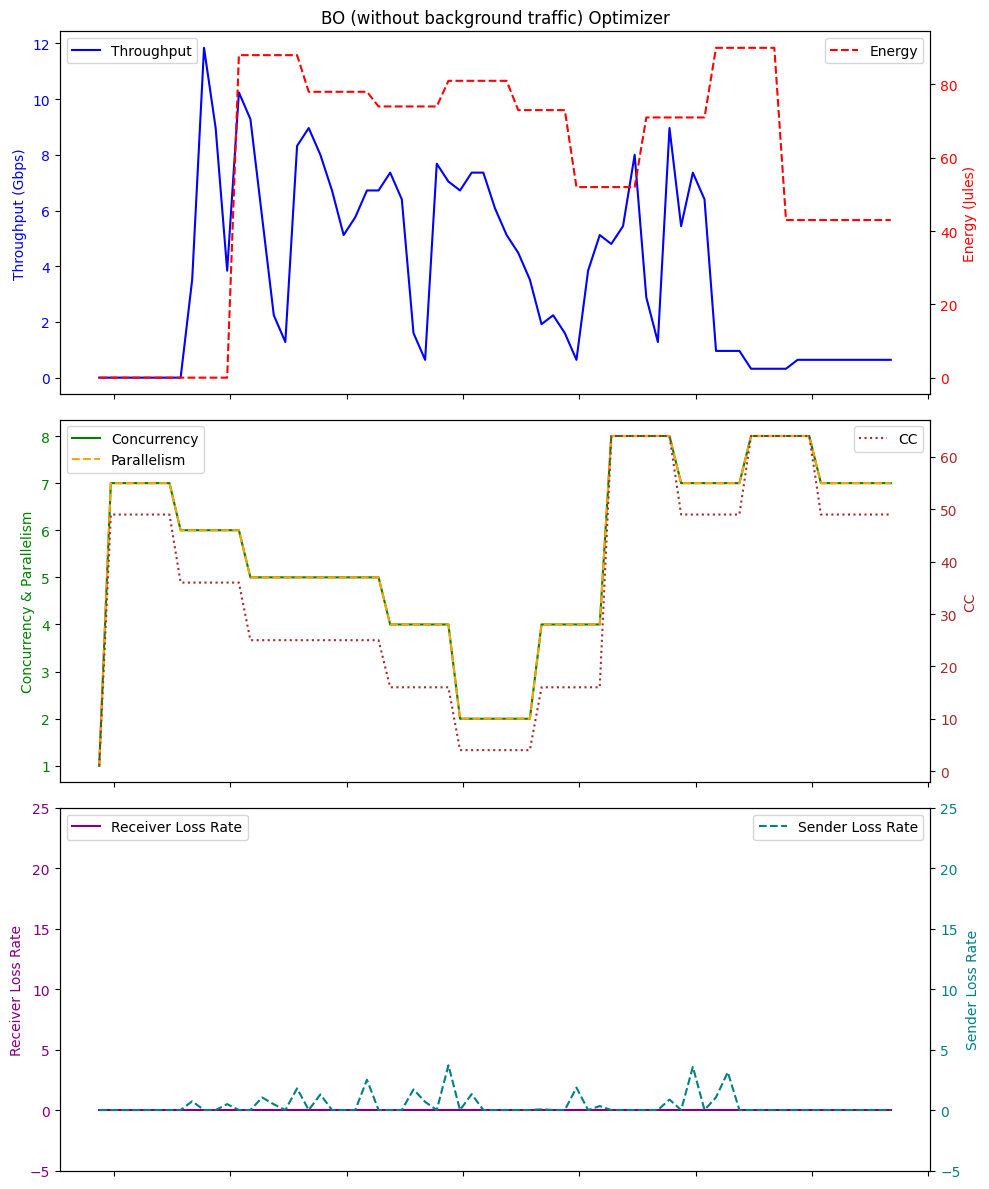

Average Throughput: 3.7750724637681152
Total Energy: 3999.0
Total loss rate: 26.563090887341772


In [2]:
# Example usage BO
directory = './logFileDir/BO/'
dfs = process_log_files(directory,"BO_logFile_")

bo_throughput_list=[]
bo_energy_list=[]
bo_plr_list=[]
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('BO (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('withBT.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['sender_lr'].sum()
    print("Total loss rate:", total_plr)
    
    bo_throughput_list.append(average_throughput)
    bo_energy_list.append(total_energy)
    bo_plr_list.append(total_plr)


                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 05:54:00.420719        0.00          0.0   1    0.0   0.0   
1  2023-12-27 05:54:01.416240        0.00          0.0   1    0.0   0.0   
2  2023-12-27 05:54:02.416176        0.00          0.0   1    0.0  32.6   
3  2023-12-27 05:54:03.418800        0.00          0.0   1    0.0  32.6   
4  2023-12-27 05:54:04.418884        0.00          0.0   1    0.0  32.7   
..                        ...         ...          ...  ..    ...   ...   
85 2023-12-27 05:55:25.491949        0.32          0.0   1    0.0  32.7   
86 2023-12-27 05:55:26.502722        0.32          0.0   1    0.0  32.7   
87 2023-12-27 05:55:27.504940        0.32          0.0   1    0.0  32.7   
88 2023-12-27 05:55:28.505737        0.32          0.0   1    0.0  32.7   
89 2023-12-27 05:55:29.506204        0.32          0.0   1    0.0  32.8   

    Energy  sender_lr  concurrency  parallelism  
0      0.0        0.0            1            1  

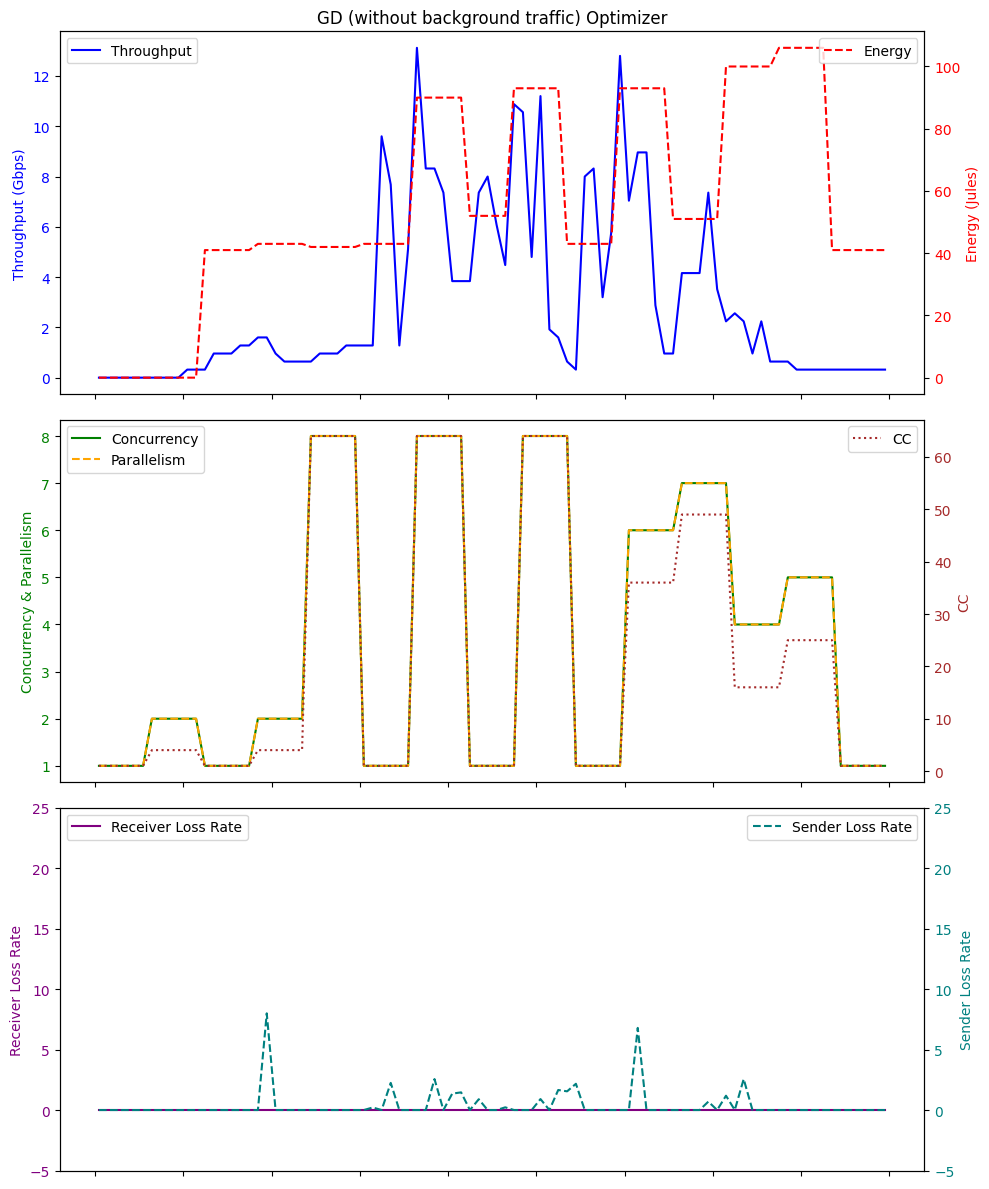

Average Throughput: 2.9795555555555557
Total Energy: 5017.0
Total loss rate: 34.45190200738003
                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-27 05:39:12.664282        0.00          0.0   1    0.0   0.0   
1   2023-12-27 05:39:13.658677        0.00          0.0   1    0.0   0.0   
2   2023-12-27 05:39:14.658521        0.00          0.0   1    0.0  32.7   
3   2023-12-27 05:39:15.660591        0.00          0.0   1    0.0  32.6   
4   2023-12-27 05:39:16.660994        0.00          0.0   1    0.0  32.7   
..                         ...         ...          ...  ..    ...   ...   
157 2023-12-27 05:41:49.822499        0.96          0.0  64    0.0  32.7   
158 2023-12-27 05:41:50.824272        0.96          0.0  64    0.0  32.8   
159 2023-12-27 05:41:51.825050        0.96          0.0  64    0.0  32.7   
160 2023-12-27 05:41:52.825955        0.96          0.0  64    0.0  32.7   
161 2023-12-27 05:41:53.828627        0.96          0.0  64    0.0  3

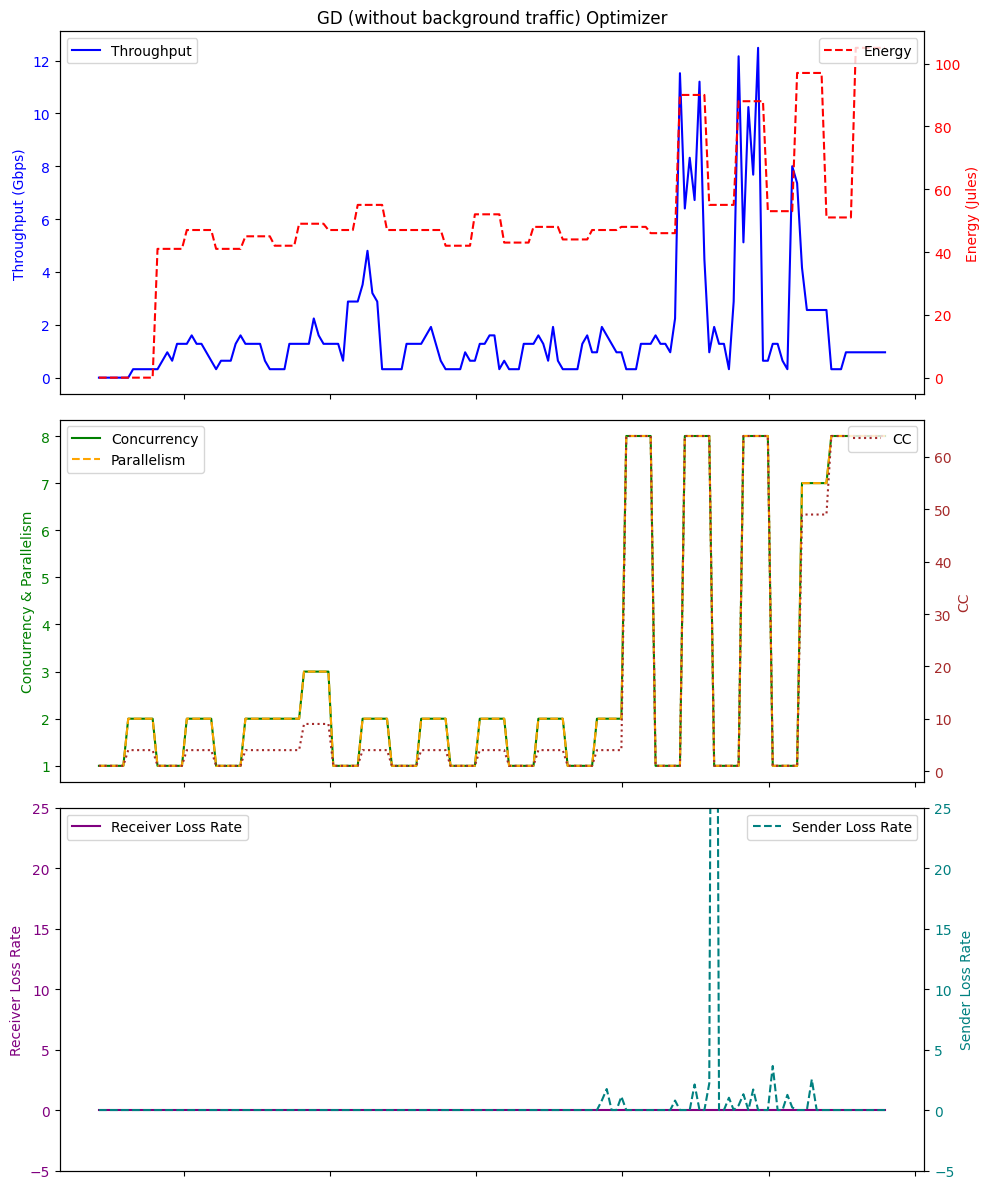

Average Throughput: 1.6967901234567904
Total Energy: 8283.0
Total loss rate: 130.81651968589762


In [3]:
# Example usage GD
directory = './logFileDir/GD/'
dfs = process_log_files(directory,"GD_logFile_")

gd_throughput_list=[]
gd_energy_list=[]
gd_plr_list=[]
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('GD (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['sender_lr'].sum()
    print("Total loss rate:", total_plr)
    
    gd_throughput_list.append(average_throughput)
    gd_energy_list.append(total_energy)
    gd_plr_list.append(total_plr)


                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 05:43:15.279500        0.00          0.0   1    0.0   0.0   
1  2023-12-27 05:43:16.275753        0.00          0.0  16    0.0   0.0   
2  2023-12-27 05:43:17.275378        0.00          0.0  16    0.0  32.8   
3  2023-12-27 05:43:18.276841        0.00          0.0  16    0.0  32.9   
4  2023-12-27 05:43:19.279187        0.00          0.0  16    0.0  32.7   
..                        ...         ...          ...  ..    ...   ...   
75 2023-12-27 05:44:30.349835        0.96          0.0   9    1.0  32.9   
76 2023-12-27 05:44:31.350961        0.96          0.0   9    1.0  32.7   
77 2023-12-27 05:44:32.351723        0.96          0.0   9    1.0  32.7   
78 2023-12-27 05:44:33.353313        0.96          0.0   9    1.0  32.8   
79 2023-12-27 05:44:34.582819        0.96          0.0   1    0.0   0.0   

    Energy  sender_lr  concurrency  parallelism  
0      0.0        0.0            1            1  

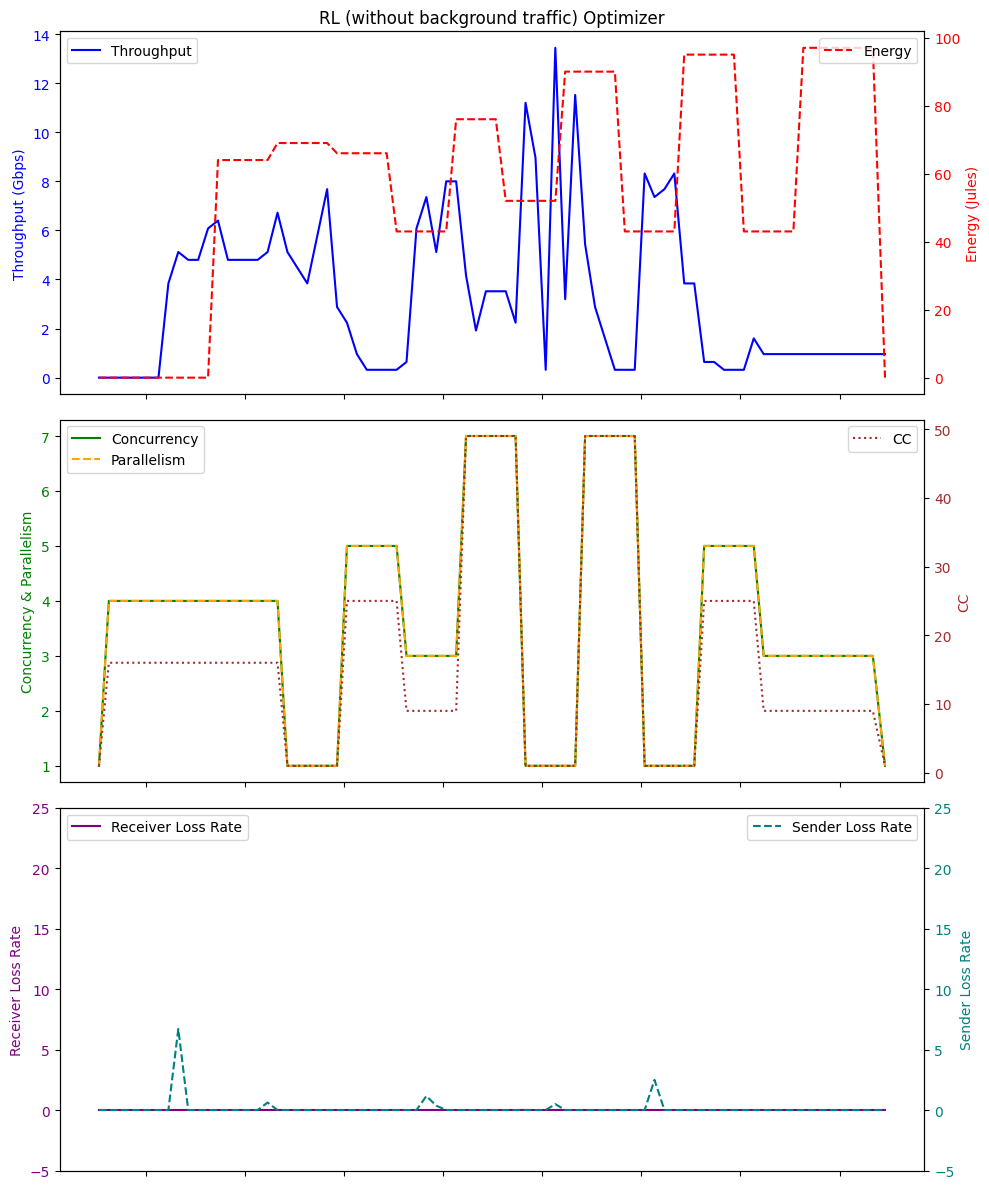

Average Throughput: 3.3200000000000003
Total Energy: 4546.0
Total loss rate: 11.82099106537598
                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 06:01:20.947488        0.00          0.0   1    0.0   0.0   
1  2023-12-27 06:01:21.937162        0.00          0.0  16    0.0   0.0   
2  2023-12-27 06:01:22.939056        0.00          0.0  16    0.0  32.8   
3  2023-12-27 06:01:23.940001        0.00          0.0  16    0.0  32.7   
4  2023-12-27 06:01:24.939853        0.00          0.0  16    0.0  32.7   
..                        ...         ...          ...  ..    ...   ...   
75 2023-12-27 06:02:36.014517        2.88          0.0  49    1.0  32.8   
76 2023-12-27 06:02:37.015816        2.88          0.0  49    1.0  32.8   
77 2023-12-27 06:02:38.016594        2.88          0.0  49    1.0  32.7   
78 2023-12-27 06:02:39.017227        2.88          0.0  49    1.0  32.8   
79 2023-12-27 06:02:41.518759        2.88          0.0   1    0.0   0.0   

    

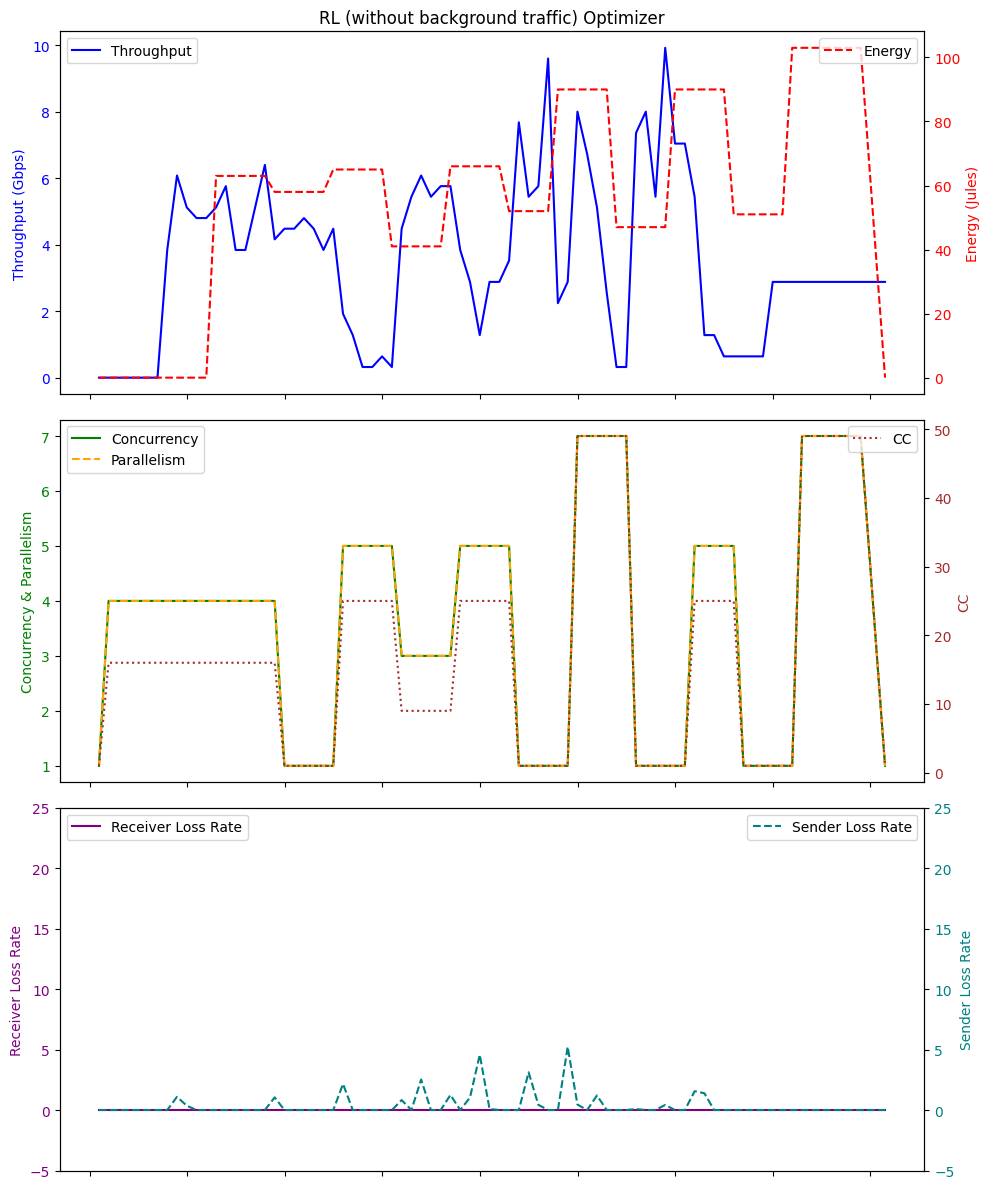

Average Throughput: 3.56
Total Energy: 4510.0
Total loss rate: 28.828180582980835


In [4]:
# Example usage RL
directory = './logFileDir/RL/'
dfs = process_log_files(directory,"RL_logFile_")

rl_throughput_list=[]
rl_energy_list=[]
rl_plr_list=[]
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('RL (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['sender_lr'].sum()
    print("Total loss rate:", total_plr)
    
    rl_throughput_list.append(average_throughput)
    rl_energy_list.append(total_energy)
    rl_plr_list.append(total_plr)


                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 05:44:36.835488        0.00          0.0  64    0.0   0.0   
1  2023-12-27 05:44:37.831398        0.00          0.0  64    0.0   0.0   
2  2023-12-27 05:44:38.833135        0.00          0.0  64    0.0  32.7   
3  2023-12-27 05:44:39.834155        0.00          0.0  64    0.0  32.8   
4  2023-12-27 05:44:40.835287        0.00          0.0  64    0.0  32.7   
5  2023-12-27 05:44:41.840786        0.00          0.0  64    0.0  32.6   
6  2023-12-27 05:44:42.869856        0.00          0.0  64    0.0  34.8   
7  2023-12-27 05:44:43.841875        0.64          0.0  64    0.0  32.8   
8  2023-12-27 05:44:44.846718       13.76          0.0  64 -240.0  33.8   
9  2023-12-27 05:44:45.835233        4.80          0.0  64    1.0  33.0   
10 2023-12-27 05:44:46.880536        9.60          0.0  64    3.0  33.0   
11 2023-12-27 05:44:47.887913        8.32          0.0  64    2.0  33.1   
12 2023-12-27 05:44:48.87

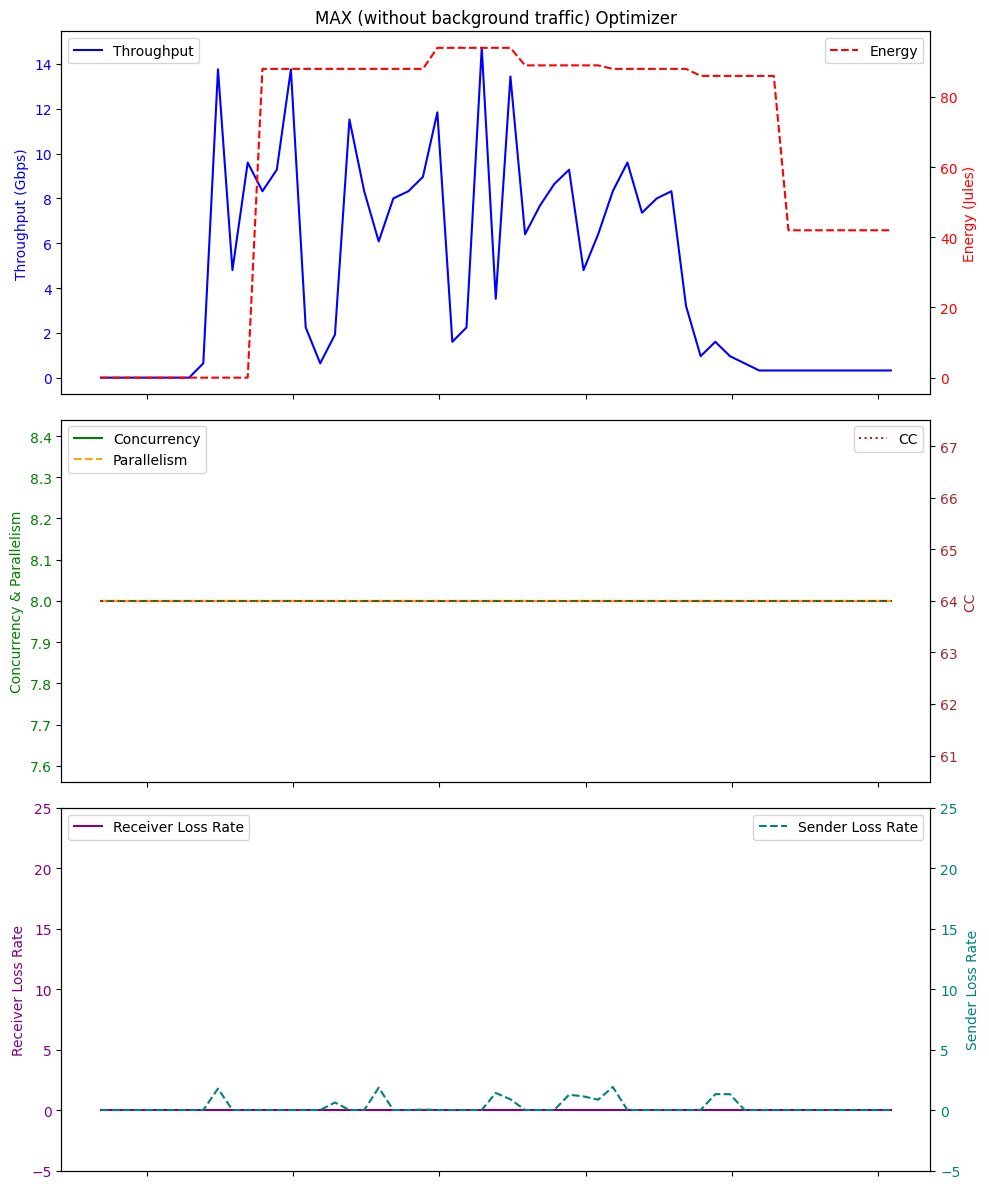

Average Throughput: 4.70690909090909
Total Energy: 3534.0
Total loss rate: 14.364912561641832
                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 06:02:43.786834        0.00          0.0  64    0.0   0.0   
1  2023-12-27 06:02:44.780864        0.00          0.0  64    0.0   0.0   
2  2023-12-27 06:02:45.780792        0.00          0.0  64    0.0  32.6   
3  2023-12-27 06:02:46.782505        0.00          0.0  64    0.0  32.8   
4  2023-12-27 06:02:47.783598        0.00          0.0  64    0.0  32.7   
..                        ...         ...          ...  ..    ...   ...   
56 2023-12-27 06:03:39.830237        0.32          0.0  64    0.0  32.9   
57 2023-12-27 06:03:40.832036        0.32          0.0  64    0.0  32.7   
58 2023-12-27 06:03:41.831947        0.32          0.0  64    0.0  32.7   
59 2023-12-27 06:03:42.833734        0.32          0.0  64    0.0  32.7   
60 2023-12-27 06:03:43.824795        0.32          0.0  64    0.0  32.7   

    E

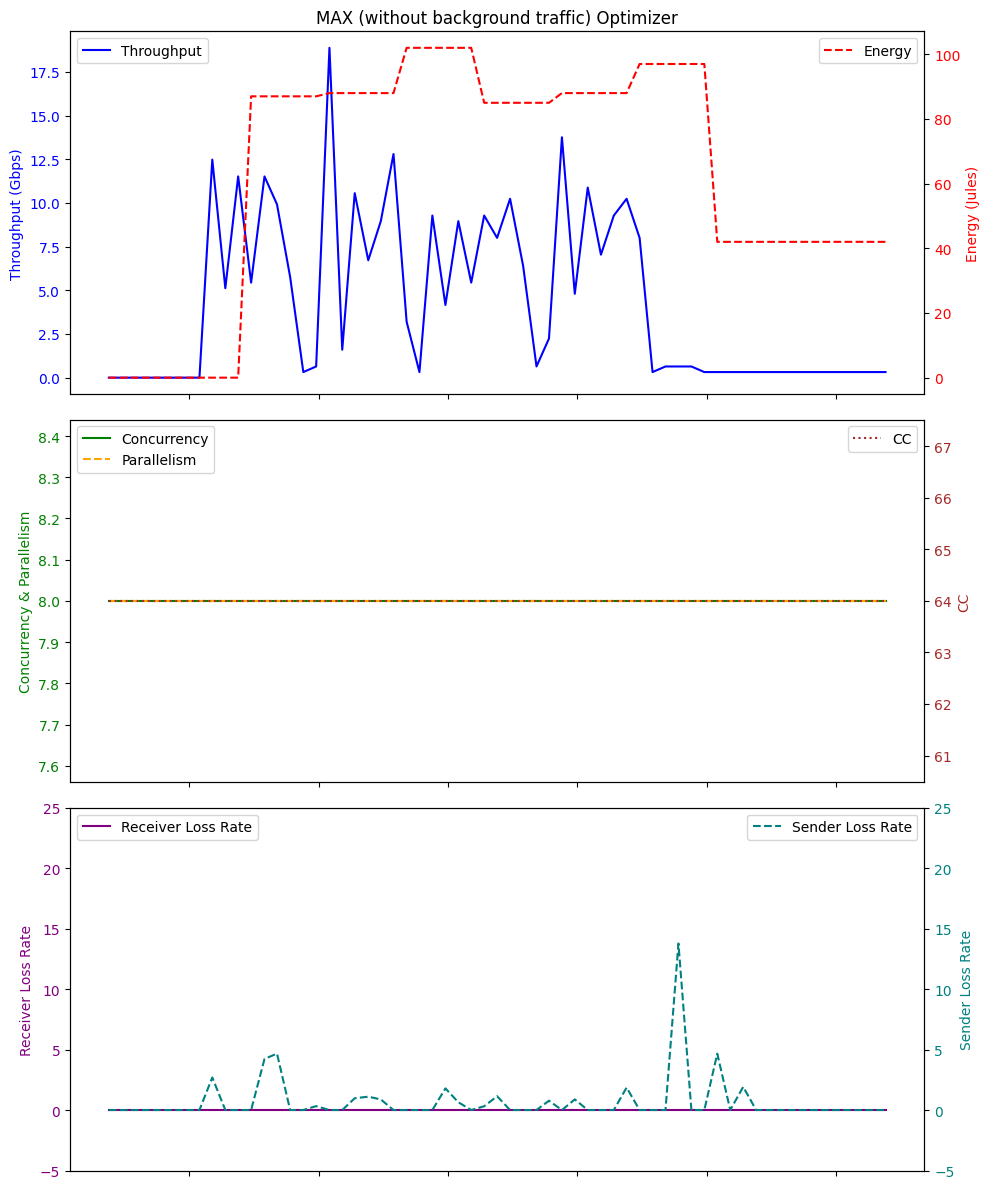

Average Throughput: 4.285901639344262
Total Energy: 3870.0
Total loss rate: 42.60638295297512


In [5]:
# Example usage MAX
directory = './logFileDir/MAX/'
dfs = process_log_files(directory,"MAX_logFile_")

max_throughput_list=[]
max_energy_list=[]
max_plr_list=[]
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('MAX (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['sender_lr'].sum()
    print("Total loss rate:", total_plr)
    
    max_throughput_list.append(average_throughput)
    max_energy_list.append(total_energy)
    max_plr_list.append(total_plr)


                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-27 05:45:34.085282        0.00          0.0   1    0.0   0.0   
1   2023-12-27 05:45:35.082024        0.00          0.0   1    0.0   0.0   
2   2023-12-27 05:45:36.083922        0.00          0.0   1    0.0  32.6   
3   2023-12-27 05:45:37.083383        0.00          0.0   1    0.0  32.7   
4   2023-12-27 05:45:38.085351        0.00          0.0   1    0.0  32.9   
..                         ...         ...          ...  ..    ...   ...   
499 2023-12-27 05:53:53.617540        0.32          0.0   1    0.0  32.7   
500 2023-12-27 05:53:54.619830        0.32          0.0   1    0.0  32.6   
501 2023-12-27 05:53:55.620654        0.32          0.0   1    0.0  32.7   
502 2023-12-27 05:53:56.623214        0.32          0.0   1    0.0  32.6   
503 2023-12-27 05:53:57.623097        0.32          0.0   1    0.0  32.7   

     Energy  sender_lr  concurrency  parallelism  
0       0.0        0.0            1 

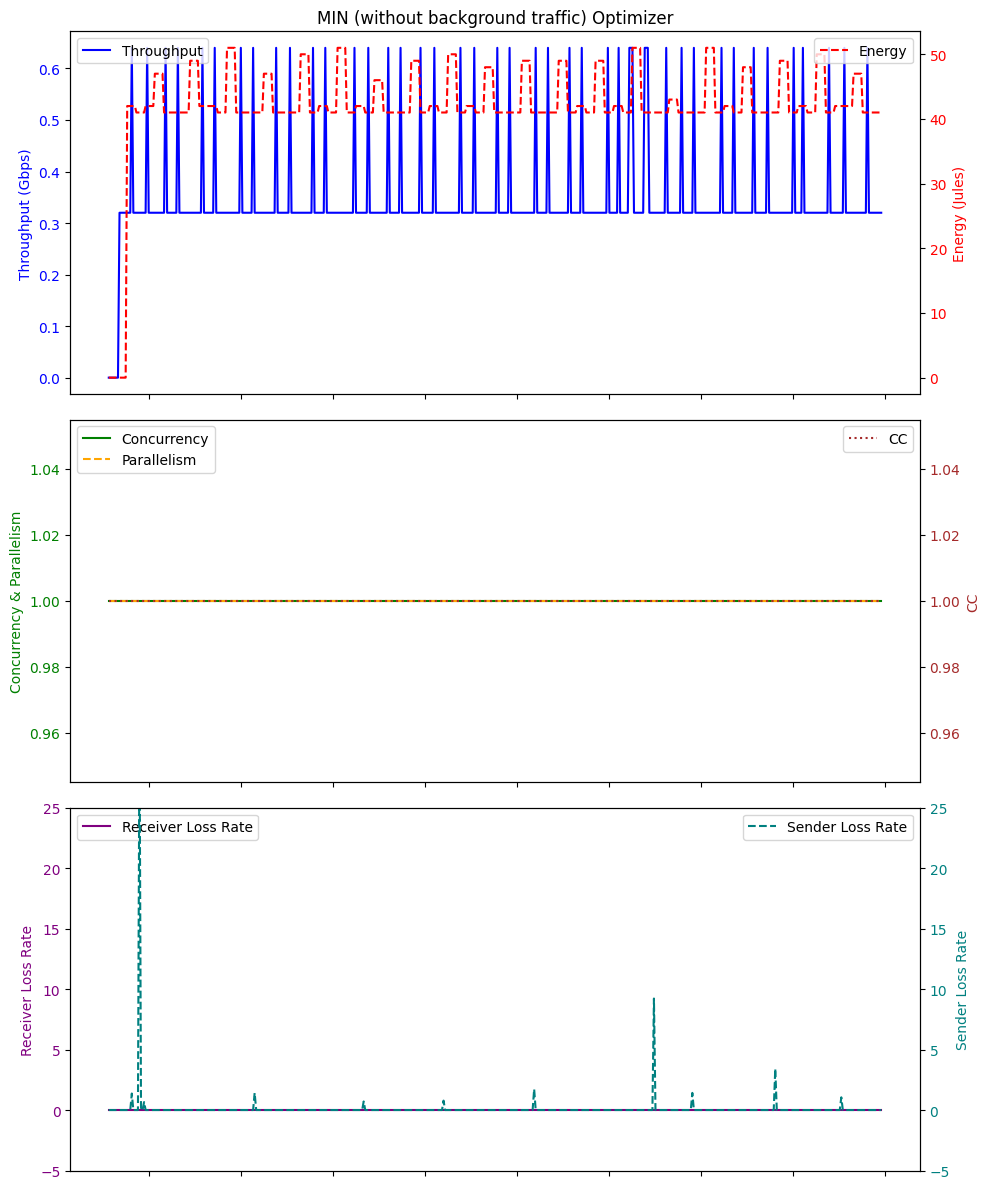

Average Throughput: 0.3447619047619048
Total Energy: 21180.0
Total loss rate: 53.924612190258415
                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-27 06:03:47.608338        0.00          0.0   1    0.0   0.0   
1   2023-12-27 06:03:48.604118        0.00          0.0   1    0.0   0.0   
2   2023-12-27 06:03:49.604438        0.00          0.0   1    0.0  32.7   
3   2023-12-27 06:03:50.606789        0.00          0.0   1    0.0  32.9   
4   2023-12-27 06:03:51.606813        0.00          0.0   1    0.0  32.6   
..                         ...         ...          ...  ..    ...   ...   
499 2023-12-27 06:12:07.144893        0.32          0.0   1    0.0  32.7   
500 2023-12-27 06:12:08.146351        0.32          0.0   1    0.0  32.8   
501 2023-12-27 06:12:09.145960        0.32          0.0   1    0.0  32.8   
502 2023-12-27 06:12:10.147509        0.32          0.0   1    0.0  32.9   
503 2023-12-27 06:12:11.147963        0.32          0.0   1    0.0 

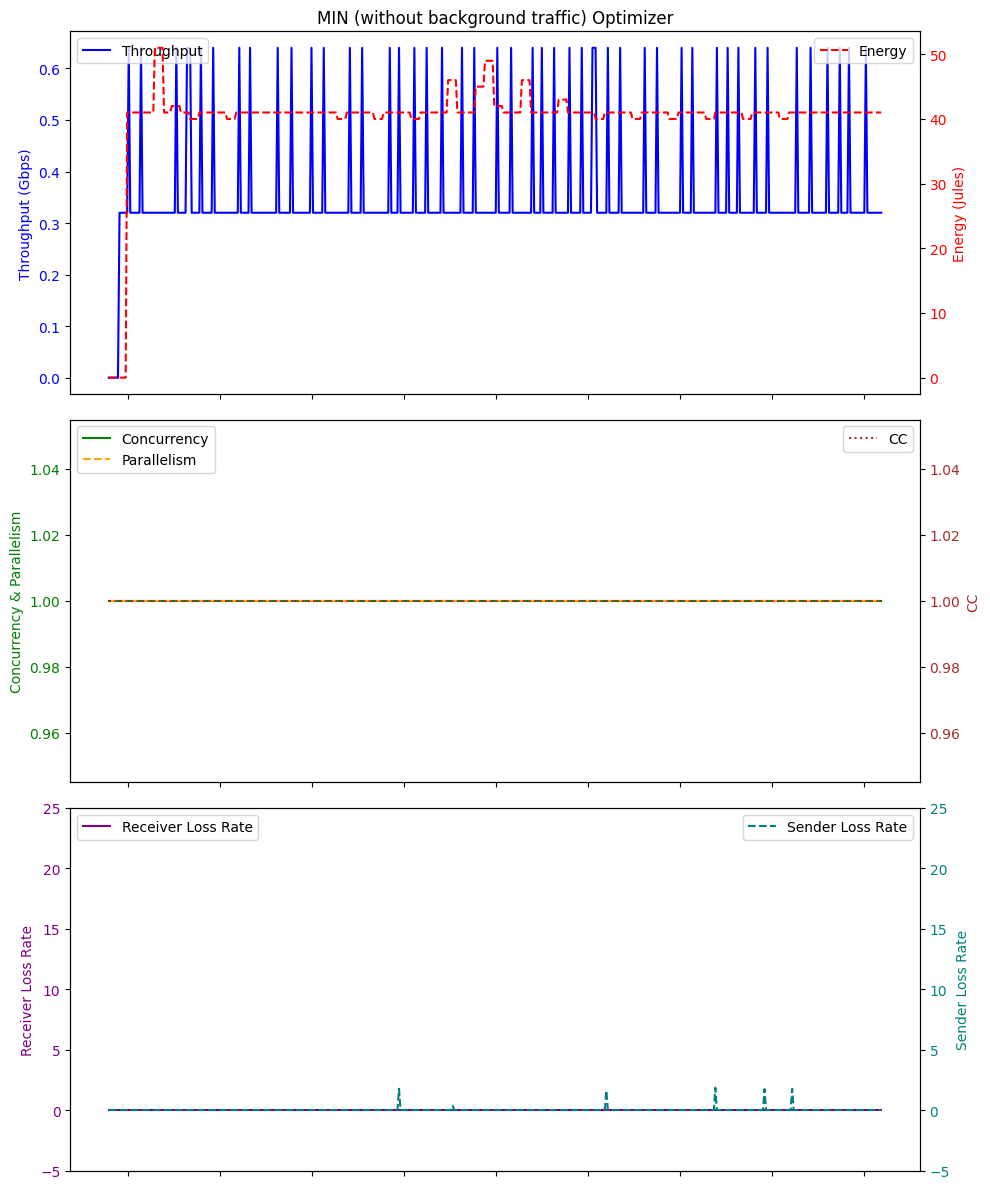

Average Throughput: 0.34730158730158733
Total Energy: 20322.0
Total loss rate: 9.062735806058193


In [6]:
# Example usage min
directory = './logFileDir/MIN/'
dfs = process_log_files(directory,"MIN_logFile_")

min_throughput_list=[]
min_energy_list=[]
min_plr_list=[]
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('MIN (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['sender_lr'].sum()
    print("Total loss rate:", total_plr)
    
    min_throughput_list.append(average_throughput)
    min_energy_list.append(total_energy)
    min_plr_list.append(total_plr)


In [9]:
result_dictionary={"Throughput":[bo_throughput_list,gd_throughput_list,rl_throughput_list,max_throughput_list,min_throughput_list],"Energy":[bo_energy_list,gd_energy_list,rl_energy_list,max_energy_list,min_energy_list],"lossRate":[bo_plr_list,gd_plr_list,rl_plr_list,max_plr_list,min_plr_list]}
print(result_dictionary)

{'Throughput': [[0.7712094395280236, 3.7750724637681152], [2.9795555555555557, 1.6967901234567904], [3.3200000000000003, 3.56], [4.70690909090909, 4.285901639344262], [0.3447619047619048, 0.34730158730158733]], 'Energy': [[14745.0, 3999.0], [5017.0, 8283.0], [4546.0, 4510.0], [3534.0, 3870.0], [21180.0, 20322.0]], 'lossRate': [[65.16971854353793, 26.563090887341772], [34.45190200738003, 130.81651968589762], [11.82099106537598, 28.828180582980835], [14.364912561641832, 42.60638295297512], [53.924612190258415, 9.062735806058193]]}


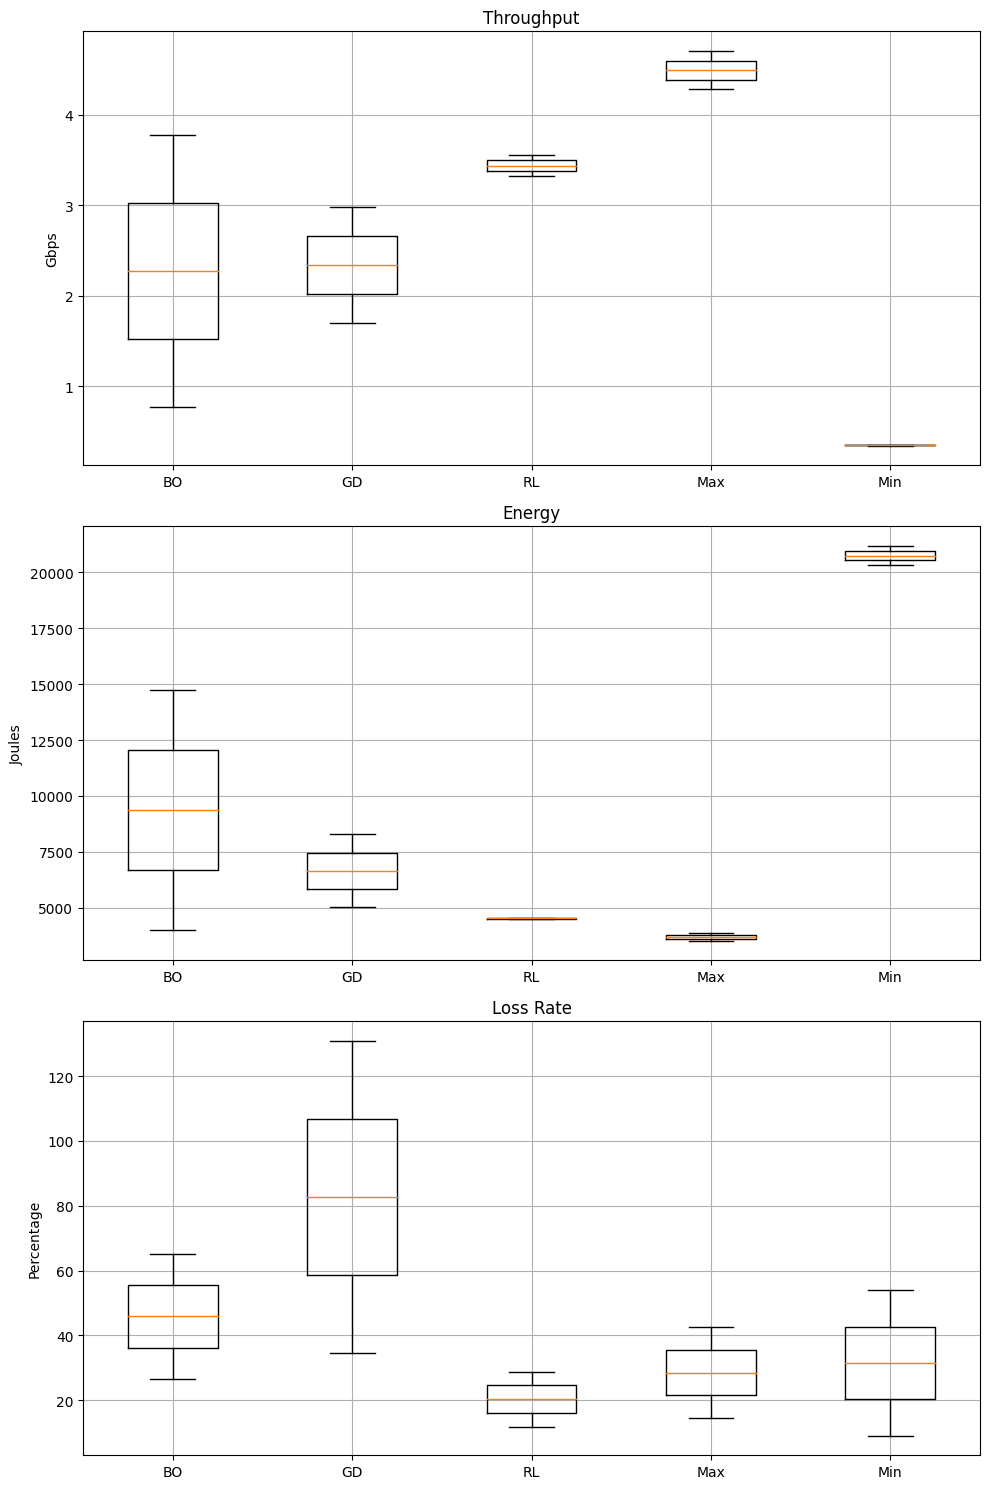

In [11]:
import matplotlib.pyplot as plt
labels = ['BO', 'GD', 'RL', 'Max', 'Min']

# Creating subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput')
axes[0].set_ylabel('Gbps')
axes[0].grid(True)  # Adding grid


# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy')
axes[1].set_ylabel('Joules')
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate')
axes[2].set_ylabel('Percentage')
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()